<a href="https://colab.research.google.com/github/NazariiDovhan19/Customer_Support_SLA_Analysis.ipynb/blob/main/Customer_Support_SLA_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Support Ticket Analysis & SLA Monitoring

This notebook analyses a support ticket dataset to understand **SLA performance**, **drivers of breaches**, and **operational improvements**.

**Key questions**
- What is overall SLA compliance (First Response & Resolution)?
- Which priorities / categories / channels / teams drive breaches?
- When do peaks happen (hour/day/week)?
- What actions would reduce breaches and improve CSAT?


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DATA_PATH = "/content/support_tickets_sla_dataset.csv"
df = pd.read_csv(DATA_PATH, parse_dates=["created_at_utc","first_response_at_utc","resolved_at_utc"])
df.head()

,ticket_id,created_at_utc,first_response_at_utc,resolved_at_utc,channel,priority,category,assigned_team,misrouted,status,csat
0,TKT-100000,2025-02-02 13:50:17,2025-02-03 02:26:38.656688078,2025-02-06 00:15:14.989468952,Web Form,P3,Bug,Engineering,0,Closed,2.7
1,TKT-100001,2025-10-10 11:51:17,2025-10-10 13:42:13.582780610,2025-10-13 09:34:58.429695722,Chat,P3,Account Update,Customer Success,0,Closed,3.4
2,TKT-100002,2025-08-27 22:02:46,2025-08-28 10:55:44.349111106,2025-08-31 03:47:28.863582886,Phone,P4,Bug,Engineering,0,Closed,4.4
3,TKT-100003,2025-06-10 04:34:30,2025-06-10 21:59:09.577389618,2025-06-15 18:40:16.903161150,Chat,P4,Billing,Billing Ops,0,Closed,3.2
4,TKT-100004,2025-06-08 01:12:48,2025-06-08 05:25:55.842670722,2025-06-09 05:44:29.943379002,Email,P3,Other,Customer Success,1,Closed,3.5


In [3]:
# Feature engineering
df["response_time_min"] = (df["first_response_at_utc"] - df["created_at_utc"]).dt.total_seconds() / 60
df["resolution_time_min"] = (df["resolved_at_utc"] - df["created_at_utc"]).dt.total_seconds() / 60

sla_resp = {"P1":30, "P2":120, "P3":480, "P4":1440}
sla_res  = {"P1":480, "P2":1440, "P3":4320, "P4":10080}

df["sla_response_target_min"] = df["priority"].map(sla_resp)
df["sla_resolution_target_min"] = df["priority"].map(sla_res)

df["response_breach"] = (df["response_time_min"] > df["sla_response_target_min"]).astype(int)
df["resolution_breach"] = (df["resolution_time_min"] > df["sla_resolution_target_min"]).astype(int)

# Time features (UK time)
created_uk = df["created_at_utc"].dt.tz_localize("UTC").dt.tz_convert("Europe/London")
df["created_hour_uk"] = created_uk.dt.hour
df["created_weekday_uk"] = created_uk.dt.day_name()
df["created_date_uk"] = created_uk.dt.date

df[["response_time_min","resolution_time_min","response_breach","resolution_breach"]].describe()

,response_time_min,resolution_time_min,response_breach,resolution_breach
count,18000.000000,18000.000000,18000.000000,18000.000000
mean,562.659128,6317.943238,0.281833,0.412500
std,629.213763,7155.748079,0.449905,0.492298
min,4.160492,42.428036,0.000000,0.000000
25%,146.857776,1817.612187,0.000000,0.000000
50%,359.713638,4056.058980,0.000000,0.000000
75%,734.225723,8003.312689,1.000000,1.000000
max,7962.992585,43200.000000,1.000000,1.000000


In [4]:
# KPI summary
kpis = {
    "tickets": len(df),
    "avg_response_min": df["response_time_min"].mean(),
    "median_response_min": df["response_time_min"].median(),
    "avg_resolution_min": df["resolution_time_min"].mean(),
    "median_resolution_min": df["resolution_time_min"].median(),
    "response_sla_compliance_%": (1 - df["response_breach"].mean())*100,
    "resolution_sla_compliance_%": (1 - df["resolution_breach"].mean())*100,
    "avg_csat": df["csat"].mean(),
}
pd.Series(kpis).to_frame("value")

,value
tickets,18000.000000
avg_response_min,562.659128
median_response_min,359.713638
avg_resolution_min,6317.943238
median_resolution_min,4056.058980
response_sla_compliance_%,71.816667
resolution_sla_compliance_%,58.750000
avg_csat,3.600178


In [5]:
# SLA compliance by priority
by_pri = df.groupby("priority").agg(
    tickets=("ticket_id","count"),
    response_compliance=("response_breach", lambda s: (1-s.mean())*100),
    resolution_compliance=("resolution_breach", lambda s: (1-s.mean())*100),
    avg_csat=("csat","mean"),
    avg_response_min=("response_time_min","mean"),
    avg_resolution_min=("resolution_time_min","mean"),
).sort_index()
by_pri

,tickets,response_compliance,resolution_compliance,avg_csat,avg_response_min,avg_resolution_min
priority,,,,,,
P1,1093,56.358646,68.801464,3.692864,32.577915,461.890422
P2,3215,73.281493,67.465008,3.735925,98.565095,1446.638137
P3,8184,72.690616,52.199413,3.570711,393.796690,5814.091893
P4,5508,72.730574,61.401598,3.546333,1189.640113,11072.015687


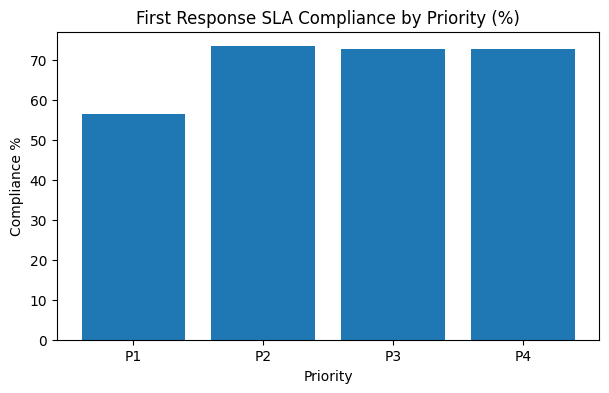

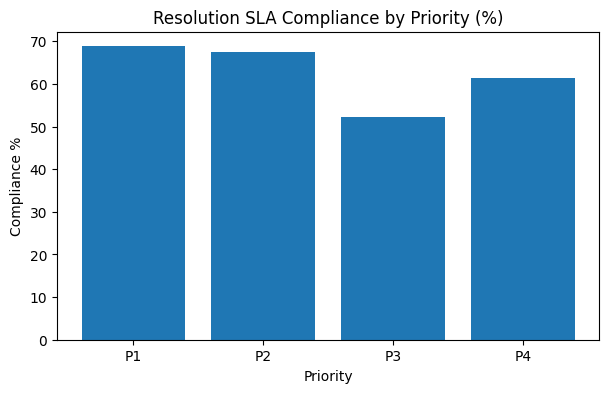

In [6]:
# Visual: SLA compliance by priority
plt.figure(figsize=(7,4))
plt.bar(by_pri.index, by_pri["response_compliance"])
plt.title("First Response SLA Compliance by Priority (%)")
plt.ylabel("Compliance %")
plt.xlabel("Priority")
plt.show()

plt.figure(figsize=(7,4))
plt.bar(by_pri.index, by_pri["resolution_compliance"])
plt.title("Resolution SLA Compliance by Priority (%)")
plt.ylabel("Compliance %")
plt.xlabel("Priority")
plt.show()

In [7]:
# Breach drivers: category / channel / team
def compliance_table(dim: str):
    t = df.groupby(dim).agg(
        tickets=("ticket_id","count"),
        response_compliance=("response_breach", lambda s: (1-s.mean())*100),
        resolution_compliance=("resolution_breach", lambda s: (1-s.mean())*100),
        avg_csat=("csat","mean"),
        avg_response_min=("response_time_min","mean"),
        avg_resolution_min=("resolution_time_min","mean"),
    ).sort_values("tickets", ascending=False)
    return t

cat_tbl = compliance_table("category")
chan_tbl = compliance_table("channel")
team_tbl = compliance_table("assigned_team")

cat_tbl.head(10), chan_tbl, team_tbl

(                 tickets  response_compliance  resolution_compliance  \
 category                                                               
 Bug                 3624            72.130243              24.889625   
 Billing             2918            71.590130              75.702536   
 Login/Access        2452            72.675367              84.869494   
 Delivery            2161            71.355854              70.985655   
 Refund              1858            71.851453              67.115178   
 Feature Request     1799            70.817121               5.113952   
 Other               1780            71.966292              80.842697   
 Account Update      1408            71.732955              76.065341   
 
                  avg_csat  avg_response_min  avg_resolution_min  
 category                                                         
 Bug              3.378918        570.407363         9423.643321  
 Billing          3.725565        556.762819         4127.477306  


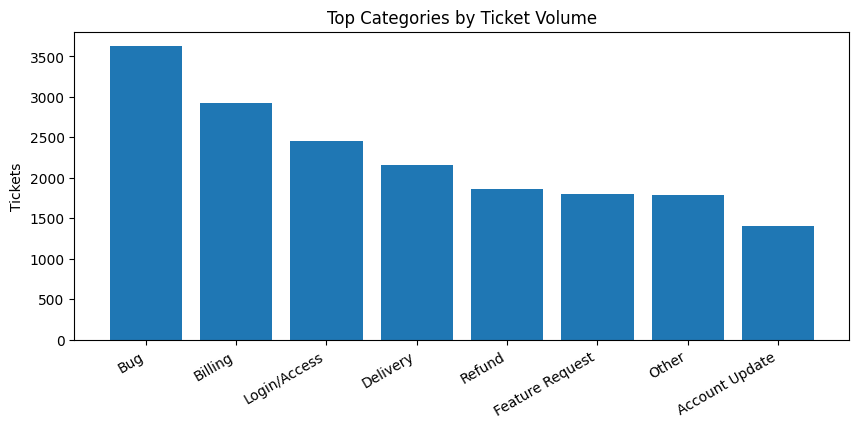

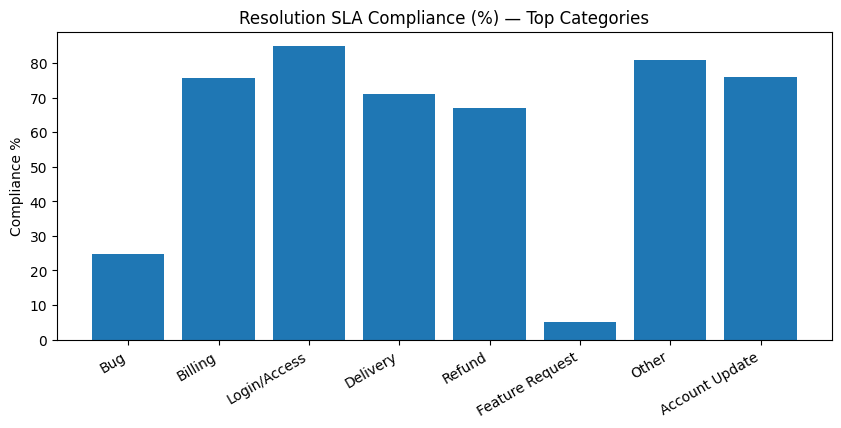

In [8]:
# Visual: Top 8 categories by ticket volume + resolution compliance
top_cat = cat_tbl.head(8).copy()

plt.figure(figsize=(10,4))
plt.bar(top_cat.index, top_cat["tickets"])
plt.title("Top Categories by Ticket Volume")
plt.ylabel("Tickets")
plt.xticks(rotation=30, ha="right")
plt.show()

plt.figure(figsize=(10,4))
plt.bar(top_cat.index, top_cat["resolution_compliance"])
plt.title("Resolution SLA Compliance (%) — Top Categories")
plt.ylabel("Compliance %")
plt.xticks(rotation=30, ha="right")
plt.show()

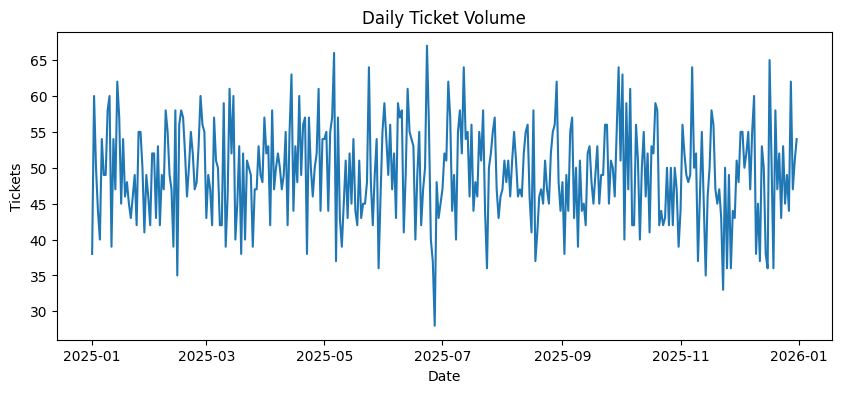

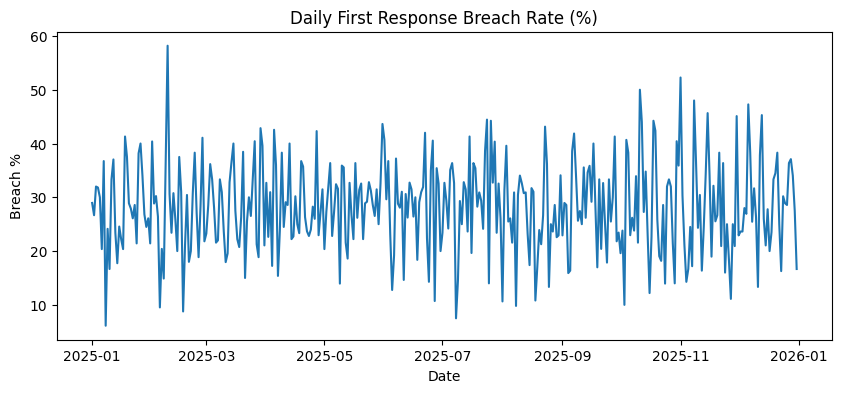

In [9]:
# Time patterns: daily volume and breaches
daily = df.groupby("created_date_uk").agg(
    tickets=("ticket_id","count"),
    response_breach_rate=("response_breach","mean"),
    resolution_breach_rate=("resolution_breach","mean"),
).reset_index()

plt.figure(figsize=(10,4))
plt.plot(pd.to_datetime(daily["created_date_uk"]), daily["tickets"])
plt.title("Daily Ticket Volume")
plt.ylabel("Tickets")
plt.xlabel("Date")
plt.show()

plt.figure(figsize=(10,4))
plt.plot(pd.to_datetime(daily["created_date_uk"]), daily["response_breach_rate"]*100)
plt.title("Daily First Response Breach Rate (%)")
plt.ylabel("Breach %")
plt.xlabel("Date")
plt.show()

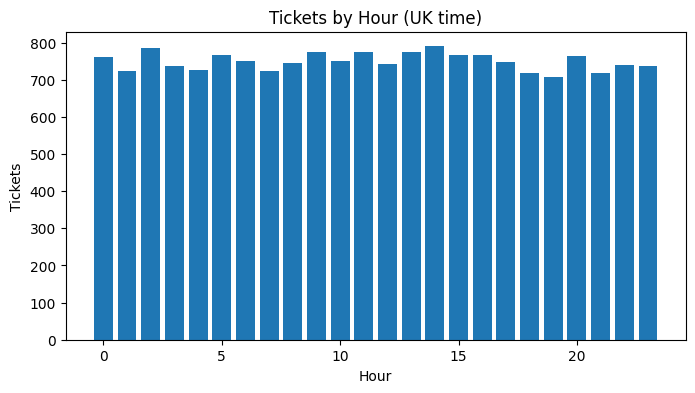

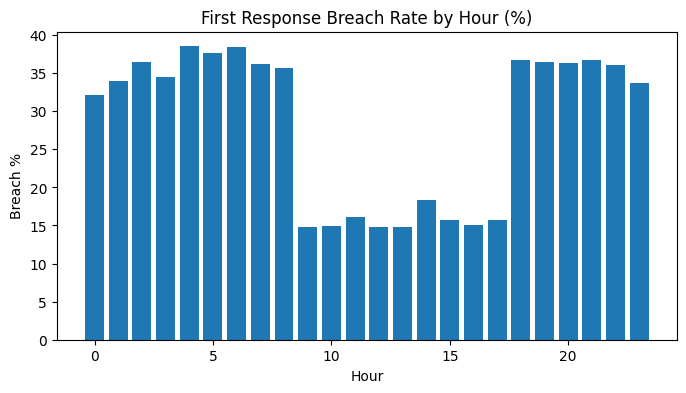

In [10]:
# Intraday: volume by hour (UK time)
hourly = df.groupby("created_hour_uk").agg(
    tickets=("ticket_id","count"),
    response_breach_rate=("response_breach","mean"),
    resolution_breach_rate=("resolution_breach","mean"),
).reset_index()

plt.figure(figsize=(8,4))
plt.bar(hourly["created_hour_uk"], hourly["tickets"])
plt.title("Tickets by Hour (UK time)")
plt.xlabel("Hour")
plt.ylabel("Tickets")
plt.show()

plt.figure(figsize=(8,4))
plt.bar(hourly["created_hour_uk"], hourly["response_breach_rate"]*100)
plt.title("First Response Breach Rate by Hour (%)")
plt.xlabel("Hour")
plt.ylabel("Breach %")
plt.show()

In [11]:
# Impact of misrouting
mis = df.groupby("misrouted").agg(
    tickets=("ticket_id","count"),
    response_compliance=("response_breach", lambda s: (1-s.mean())*100),
    resolution_compliance=("resolution_breach", lambda s: (1-s.mean())*100),
    avg_csat=("csat","mean"),
    avg_response_min=("response_time_min","mean"),
    avg_resolution_min=("resolution_time_min","mean"),
)
mis.index = ["Not misrouted","Misrouted"]
mis

,tickets,response_compliance,resolution_compliance,avg_csat,avg_response_min,avg_resolution_min
Not misrouted,15902,73.607093,60.074205,3.618388,540.285654,6197.857567
Misrouted,2098,58.245949,48.713060,3.462154,732.241101,7228.144547


## Recommendations (example structure)

Use the analysis tables above to write **clear actions**:

1. **Staffing / Scheduling**
   - Increase coverage in high-breach hours and weekends.
2. **Routing improvements**
   - Reduce misroutes (triage rules, category validation).
3. **Category playbooks**
   - Create standard resolution steps for categories driving resolution breaches (e.g., Bugs, Billing).
4. **SLA alerts**
   - Auto-alert tickets at 70% of SLA target and escalate at 90%.
5. **Quality**
   - Reduce rework by improving first-contact resolution; track reopen rate.

In your GitHub README, highlight:
- Overall compliance (%)
- Worst 3 drivers (category/team/time)
- 3–5 actions with estimated impact

Author Nazarii Dovhan
